# Import

In [68]:
import math
import json
from timeit import default_timer as timer
import concurrent.futures as cf # doesn't work with sklearn
import pandas as pd
import numpy as np
import copy as copy
import statistics as stt
import seaborn as sns
from os import system, getcwd, startfile
from os.path import join
from time import time
from scipy.io import arff
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from matplotlib import pyplot as plt
from matplotlib.ticker import FormatStrFormatter

In [85]:
print_flag = False
print_result_flag = False
plot_flag = False

class algorithmOperation():
    def get_data(self):
#         path = join(getcwd(), 'wdbc.data').replace('\\', '/')
        path = join(getcwd().rstrip('src'), 'data/wdbc.data').replace('\\', '/')
        self.data = pd.read_csv(path, header=None)
        if print_flag:
            print(self.data)
            print(self.data.shape)
            print(self.data.columns)
            print(self.data.head())

    def set_column_names(self):
        column_names = ['id', 'malignant',
                        'nucleus_mean', 'nucleus_se', 'nucleus_worst',
                        'texture_mean', 'texture_se', 'texture_worst',
                        'perimeter_mean', 'perimeter_se', 'perimeter_worst',
                        'area_mean', 'area_se', 'area_worst',
                        'smoothness_mean', 'smoothness_se', 'smoothness_worst',
                        'compactness_mean', 'compactness_se', 'compactness_worst',
                        'concavity_mean', 'concavity_se', 'concavity_worst',
                        'concave_pts_mean', 'concave_pts_se', 'concave_pts_worst',
                        'symmetry_mean', 'symmetry_se', 'symmetry_worst',
                        'fractal_dim_mean', 'fractal_dim_se', 'fractal_dim_worst'
                        ]

        self.data.columns = column_names
        if print_flag:
            print(self.data.shape)
            print(self.data.columns)
            print(self.data.head())
            self.data.tail(10)

    def make_data_all_numerical(self):
        self.data['malignant'] = self.data['malignant'].map(
            lambda x: 0 if x == 'B' else 1)
        if print_flag:
            self.data.tail(10)

    def split_data_into_train_test(self, sds):
        self.X = self.data.drop(columns=['malignant']).values
        
        if sds:
            # for scaled data
            ss = StandardScaler()
            self.X = ss.fit_transform(self.X)
        
        self.y = self.data['malignant'].values
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            self.X, self.y, test_size=0.25, random_state=2018)

    def build_mldl_model(self, n, depth=-1):
        # .0 original
        # .1 depth/iter
        # .5 class_weight
        if n == '1.0':
            self.model = DecisionTreeClassifier()
        if n == '1.1':
            self.model = DecisionTreeClassifier(max_depth=depth)
        if n == '1.5':
            self.model = DecisionTreeClassifier(class_weight='balanced')
        if n == '2.0':
            self.model = RandomForestClassifier()
        if n == '2.1':
            self.model = RandomForestClassifier(max_depth=depth)
        if n == '2.5':
            self.model = RandomForestClassifier(class_weight='balanced')
        if n == '3.0':
            self.model = KNeighborsClassifier()
        if n == '3.1':
            # https://stackoverflow.com/questions/71089359/trouble-with-python-iteration-of-knn-scores
            self.model = KNeighborsClassifier(n_neighbors=depth)
        if n == '3.5':
            self.model = KNeighborsClassifier(weights='distance')
        if n == '4.0':
            self.model = SVC()
        if n == '4.1':
            self.model = SVC(max_iter=depth)
        if n == '4.5':
            self.model = SVC(class_weight='balanced')
        if n == '5.0':
            self.model = LogisticRegression()
        if n == '5.1':
            self.model = LogisticRegression(max_iter=depth)
        if n == '5.5':
            self.model = LogisticRegression(class_weight='balanced')

    def training_mldl_model(self):
        self.model.fit(self.X_train, self.y_train)

    def test_mldl_model(self):
        self.y_pred = self.model.predict(self.X_test)

    def evaluate_the_result(self, n):
        if self.y_pred.all == self.y_test.all:
            print('Prediction successful, all values are same') if print_result_flag else None
        else:
            self.y_diff = abs(self.y_pred - self.y_test)
            self.y_diff_n = (len(self.y_test)-sum(self.y_diff))/len(self.y_test)*100

    def prepare_data(self, sds):
        self.get_data()
        self.set_column_names()
        self.make_data_all_numerical()
        self.split_data_into_train_test(sds)

    def training_and_testing(self, n, depth=-1):
        self.build_mldl_model(n, depth)
        t1 = timer()
        self.training_mldl_model()
        t2 = timer()
        self.test_mldl_model()
        t3 = timer()
        self.evaluate_the_result(n)
        return [t2-t1, t3-t2]
        
    def single_run1(self, n, sds):
        # n: choosing algorithm
        # sds: turn on or off data scalling
        self.prepare_data(sds)
        if n == 1:
            self.training_and_testing('1.0')
        elif n == 2:
            self.training_and_testing('2.0')
        elif n == 3:
            self.training_and_testing('3.0')
        elif n == 4:
            self.training_and_testing('4.0')
        elif n == 5:
            self.training_and_testing('5.0')
        else:
            print('input errer')
        return self.y_diff_n
    
    def q2_1(self, sds):
        # DT ======================================================================================
        self.prepare_data(sds)
        # split into train test sets
        X_train, X_test, y_train, y_test = self.X_train, self.X_test, self.y_train, self.y_test
        # define lists to collect scores
        train_scores, test_scores = list(), list()
        # define the tree depths to evaluate
        values = [i for i in range(1, 21)]
        # evaluate a decision tree for each depth
        for i in values:
            # configure the model
            model = DecisionTreeClassifier(max_depth=i)
            # fit model on the training dataset
            model.fit(X_train, y_train)
            # evaluate on the train dataset
            train_yhat = model.predict(X_train)
            train_acc = accuracy_score(y_train, train_yhat)
            train_scores.append(train_acc)
            # evaluate on the test dataset
            test_yhat = model.predict(X_test)
            test_acc = accuracy_score(y_test, test_yhat)
            test_scores.append(test_acc)
            # summarize progress
#             print('>%d, train: %.3f, test: %.3f' % (i, train_acc, test_acc))
        # plot of train and test scores vs tree depth
        plt.plot(values, train_scores, '-o', label='Train')
        plt.plot(values, test_scores, '-o', label='Test')
        plt.legend()
        plt.title('DT')
        plt.show()
        plt.close()
        
    def q2_2(self, sds):
        # RF ======================================================================================
        self.prepare_data(sds)
        # split into train test sets
        X_train, X_test, y_train, y_test = self.X_train, self.X_test, self.y_train, self.y_test
        # define lists to collect scores
        train_scores, test_scores = list(), list()
        # define the tree depths to evaluate
        values = [i for i in range(1, 21)]
        # evaluate a decision tree for each depth
        for i in values:
            # configure the model
            model = RandomForestClassifier(max_depth=i)
            # fit model on the training dataset
            model.fit(X_train, y_train)
            # evaluate on the train dataset
            train_yhat = model.predict(X_train)
            train_acc = accuracy_score(y_train, train_yhat)
            train_scores.append(train_acc)
            # evaluate on the test dataset
            test_yhat = model.predict(X_test)
            test_acc = accuracy_score(y_test, test_yhat)
            test_scores.append(test_acc)
            # summarize progress
#             print('>%d, train: %.3f, test: %.3f' % (i, train_acc, test_acc))
        # plot of train and test scores vs tree depth
        plt.plot(values, train_scores, '-o', label='Train')
        plt.plot(values, test_scores, '-o', label='Test')
        plt.legend()
        plt.title('RF')
        plt.show()
        
    def q2_3(self, sds):
        # KNN ======================================================================================
        self.prepare_data(sds)
        # split into train test sets
        X_train, X_test, y_train, y_test = self.X_train, self.X_test, self.y_train, self.y_test
        # define lists to collect scores
        train_scores, test_scores = list(), list()
        # define the tree depths to evaluate
        values = [i for i in range(1, 21)]
        # evaluate a decision tree for each depth
        for i in values:
            # configure the model
            model = KNeighborsClassifier(n_neighbors=i)
            # fit model on the training dataset
            model.fit(X_train, y_train)
            # evaluate on the train dataset
            train_yhat = model.predict(X_train)
            train_acc = accuracy_score(y_train, train_yhat)
            train_scores.append(train_acc)
            # evaluate on the test dataset
            test_yhat = model.predict(X_test)
            test_acc = accuracy_score(y_test, test_yhat)
            test_scores.append(test_acc)
            # summarize progress
#             print('>%d, train: %.3f, test: %.3f' % (i, train_acc, test_acc))
        # plot of train and test scores vs tree depth
        plt.plot(values, train_scores, '-o', label='Train')
        plt.plot(values, test_scores, '-o', label='Test')
        plt.legend()
        plt.title('KNN')
        plt.show()
        
    def q2_4(self, sds):
        # SVM ======================================================================================
        self.prepare_data(sds)
        # split into train test sets
        X_train, X_test, y_train, y_test = self.X_train, self.X_test, self.y_train, self.y_test
        # define lists to collect scores
        train_scores, test_scores = list(), list()
        # define the tree depths to evaluate
        values = [i for i in range(1, 21)]
        # evaluate a decision tree for each depth
        for i in values:
            # configure the model
            model = SVC(max_iter=i)
            # fit model on the training dataset
            model.fit(X_train, y_train)
            # evaluate on the train dataset
            train_yhat = model.predict(X_train)
            train_acc = accuracy_score(y_train, train_yhat)
            train_scores.append(train_acc)
            # evaluate on the test dataset
            test_yhat = model.predict(X_test)
            test_acc = accuracy_score(y_test, test_yhat)
            test_scores.append(test_acc)
            # summarize progress
#             print('>%d, train: %.3f, test: %.3f' % (i, train_acc, test_acc))
        # plot of train and test scores vs tree depth
        plt.plot(values, train_scores, '-o', label='Train')
        plt.plot(values, test_scores, '-o', label='Test')
        plt.legend()
        plt.title('SVM')
        plt.show()
    
    def q2_5(self, sds):
        # LR  ======================================================================================
        self.prepare_data(sds)
        # split into train test sets
        X_train, X_test, y_train, y_test = self.X_train, self.X_test, self.y_train, self.y_test
        # define lists to collect scores
        train_scores, test_scores = list(), list()
        # define the tree depths to evaluate
        values = [i for i in range(1, 21)]
        # evaluate a decision tree for each depth
        for i in values:
            # configure the model
            model = LogisticRegression(max_iter=i)
            # fit model on the training dataset
            model.fit(X_train, y_train)
            # evaluate on the train dataset
            train_yhat = model.predict(X_train)
            train_acc = accuracy_score(y_train, train_yhat)
            train_scores.append(train_acc)
            # evaluate on the test dataset
            test_yhat = model.predict(X_test)
            test_acc = accuracy_score(y_test, test_yhat)
            test_scores.append(test_acc)
            # summarize progress
#             print('>%d, train: %.3f, test: %.3f' % (i, train_acc, test_acc))
        # plot of train and test scores vs tree depth
        plt.plot(values, train_scores, '-o', label='Train')
        plt.plot(values, test_scores, '-o', label='Test')
        plt.legend()
        plt.title('LR')
        plt.show()
        
    def single_run5(self, n, sds):
        # n: choosing algorithm
        # sds: turn on or off data scalling
        self.prepare_data(sds)
        if n == 1:
            self.training_and_testing('1.5')
        elif n == 2:
            self.training_and_testing('2.5')
        elif n == 3:
            self.training_and_testing('3.5')
        elif n == 4:
            self.training_and_testing('4.5')
        elif n == 5:
            self.training_and_testing('5.5')
        else:
            print('input errer')
        return self.y_diff_n
    
    def single_run7(self, n, sds):
        # n: choosing algorithm
        # sds: turn on or off data scalling
        # t1: training time
        # t2: test time
        self.prepare_data(sds)
        if n == 1:
            t1, t2 = self.training_and_testing('1.0')
        elif n == 2:
            t1, t2 = self.training_and_testing('2.0')
        elif n == 3:
            t1, t2 = self.training_and_testing('3.0')
        elif n == 4:
            t1, t2 = self.training_and_testing('4.0')
        elif n == 5:
            t1, t2 = self.training_and_testing('5.0')
        else:
            print('input errer')
        return t1
    
    def single_run8(self, n, sds):
        # n: choosing algorithm
        # sds: turn on or off data scalling
        # t1: training time
        # t2: test time
        self.prepare_data(sds)
        if n == 1:
            t1, t2 = self.training_and_testing('1.0')
        elif n == 2:
            t1, t2 = self.training_and_testing('2.0')
        elif n == 3:
            t1, t2 = self.training_and_testing('3.0')
        elif n == 4:
            t1, t2 = self.training_and_testing('4.0')
        elif n == 5:
            t1, t2 = self.training_and_testing('5.0')
        else:
            print('input errer')
        return t2

def sr1(n, sds, times):
    result = []
    for i in range(0, times):
        ao = algorithmOperation()
        result.append(ao.single_run1(n, sds))
        del ao
    mean = stt.mean(result)
    return mean

def sr2(sds):
    ao = algorithmOperation()
    ao.q2_1(sds)
    ao.q2_2(sds)
    ao.q2_3(sds)
    ao.q2_4(sds)
    ao.q2_5(sds)
    
def sr5(n, sds, times):
    result = []
    for i in range(0, times):
        ao = algorithmOperation()
        result.append(ao.single_run5(n, sds))
        del ao
    mean = stt.mean(result)
    return mean

def sr7(n, sds, times):
    result = []
    for i in range(0, times):
        ao = algorithmOperation()
        result.append(ao.single_run7(n, sds))
        del ao
    mean = stt.mean(result)
    return mean

def sr8(n, sds, times):
    result = []
    for i in range(0, times):
        ao = algorithmOperation()
        result.append(ao.single_run8(n, sds))
        del ao
    mean = stt.mean(result)
    return mean


# Q1 (finished)
What have we learned so far in this class are (select all aplied):

1. [x] supervised classification
2. [ ] unsupervised classification
3. [ ] clustering
4. [x] binary classification
5. [ ] multi-class classsification (KNN, but not utilized)
6. [x] regression

# Q2 (finished)
Understanding what is overfitting (you may need to google to find out what is overfitting), then find out which of the following models is the easiest one to get overfitting?  You may modify your program to try them to be familiar with the behaviors.

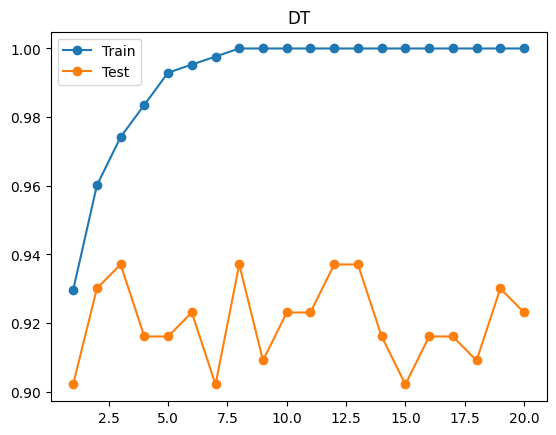

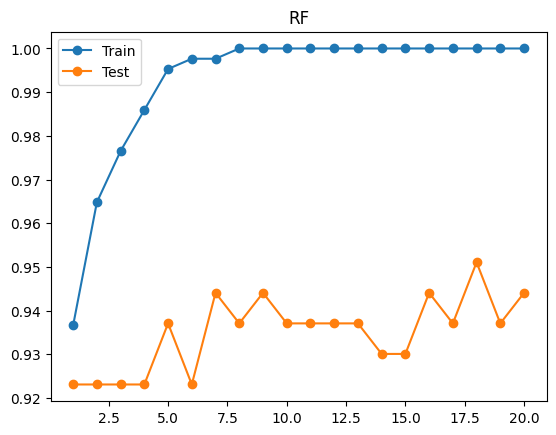

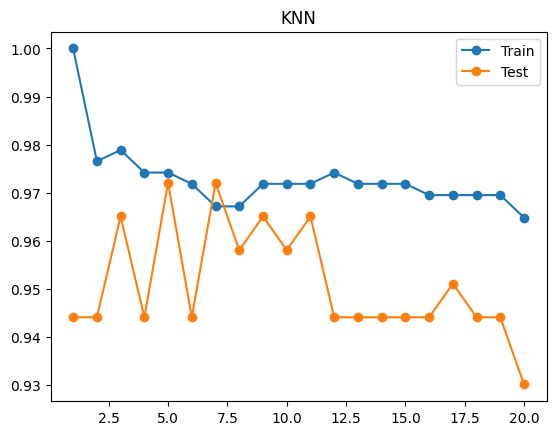

C:\Users\dachu\AppData\Roaming\Python\Python39\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\dachu\AppData\Roaming\Python\Python39\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=2).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\dachu\AppData\Roaming\Python\Python39\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=3).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\dachu\AppData\Roaming\Python\Python39\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=4).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\dachu\AppData\Roaming\Python\Python39\site-packages\skl

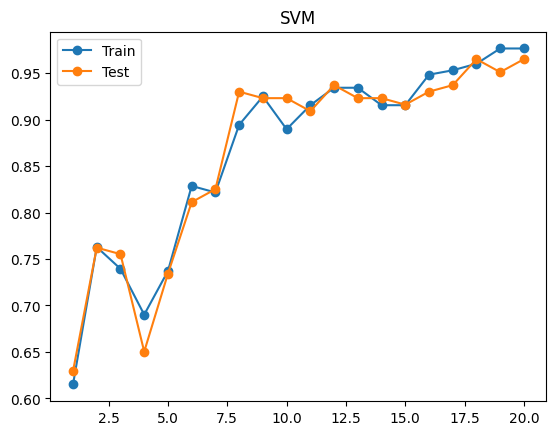

C:\Users\dachu\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\dachu\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

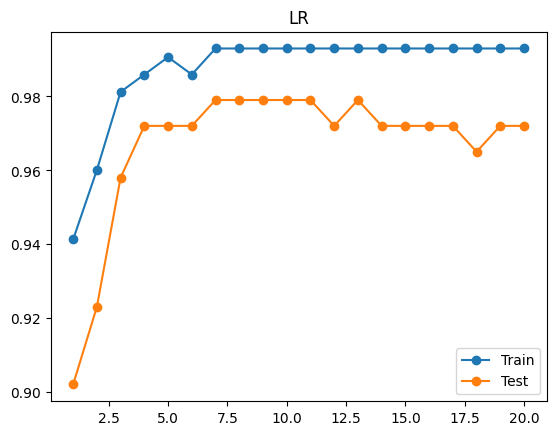

In [62]:
sr2(True)

1. [ ] Decision tree
2. [ ] Random forest
3. [x] KNN
4. [ ] SVM (need verification)
5. [ ] Logistic regression

# Q3 (finished)
Which of the following models are not sensitive to standard scaler?
Related code: [GitHub](https://github.com/belongtothenight/BD_ML_Code/blob/main/src/ML_w3_hw_q2.ipynb)

In [23]:
times = 10
unscaled = [sr1(1, False, times), sr1(2, False, times), sr1(3, False, times), sr1(4, False, times), sr1(5, False, times)]
scaled = [sr1(1, True, times), sr1(2, True, times), sr1(3, True, times), sr1(4, True, times), sr1(5, True, times)]
algorithm = ['DT', 'RF', 'KNN', 'SVC', 'LR']
diff = [scaled[i]-unscaled[i] for i in range(0, len(algorithm))]
result = pd.DataFrame(data=[algorithm, unscaled, scaled, diff], index=['algorithm', 'unscaled', 'scaled', 'diff(s-uns)'])
print(result)

                     0          1          2          3          4
algorithm           DT         RF        KNN        SVC         LR
unscaled     91.608392  93.776224  74.125874  62.237762  62.237762
scaled       91.678322  93.496503  97.202797  97.202797  96.503497
diff(s-uns)    0.06993   -0.27972  23.076923  34.965035  34.265734


1. [x] DT
2. [x] RF
3. [ ] KNN
4. [ ] SVM
5. [ ] Logistic regression (not tested)

# Q4 (finished)
Which of the following models does not have class weight support? Related code: [GitHub](https://github.com/belongtothenight/BD_ML_Code/blob/main/src/ML_w3_hw_q1.ipynb)(not accurate), and sklearn documentation.

1. [ ] DT
2. [ ] RF
3. [x] KNN
4. [ ] SVM
5. [ ] Logistic regression

# Q5 (finished)
Which of the following models does not get much help from class weight?

In [65]:
times = 10
unscaled = [sr1(1, True, times), sr1(2, True, times), sr1(3, True, times), sr1(4, True, times), sr1(5, True, times)]
scaled = [sr5(1, True, times), sr5(2, True, times), sr5(3, True, times), sr5(4, True, times), sr5(5, True, times)]
algorithm = ['DT', 'RF', 'KNN', 'SVC', 'LR']
diff = [scaled[i]-unscaled[i] for i in range(0, len(algorithm))]
result = pd.DataFrame(data=[algorithm, unscaled, scaled, diff], index=['algorithm', 'unweight', 'weighted', 'diff(s-uns)'])
print(result)

                     0          1          2          3          4
algorithm           DT         RF        KNN        SVC         LR
unweight     91.118881  93.356643  97.202797  97.202797  96.503497
weighted     93.636364  92.587413  97.202797  97.202797  97.902098
diff(s-uns)   2.517483  -0.769231        0.0        0.0   1.398601


1. [ ] DT
2. [ ] RF
3. [x] KNN
4. [x] SVM
5. [ ] Logistic regression

# Q6 (not good enough)
Which of the following models can have the largest variation of the training time with the same training data but different hyper parameters?

In [74]:
times = 1

def q6_11():
    start = timer()
    sr1(1, True, times)
    end = timer()
    elapse_time = end - start
    return elapse_time * 10

def q6_12():
    start = timer()
    sr1(2, True, times)
    end = timer()
    elapse_time = end - start
    return elapse_time * 10

def q6_13():
    start = timer()
    sr1(3, True, times)
    end = timer()
    elapse_time = end - start
    return elapse_time * 10

def q6_14():
    start = timer()
    sr1(4, True, times)
    end = timer()
    elapse_time = end - start
    return elapse_time * 10

def q6_15():
    start = timer()
    sr1(5, True, times)
    end = timer()
    elapse_time = end - start
    return elapse_time * 10

def q6_21():
    start = timer()
    sr5(1, True, times)
    end = timer()
    elapse_time = end - start
    return elapse_time * 10

def q6_22():
    start = timer()
    sr5(2, True, times)
    end = timer()
    elapse_time = end - start
    return elapse_time * 10

def q6_23():
    start = timer()
    sr5(3, True, times)
    end = timer()
    elapse_time = end - start
    return elapse_time * 10

def q6_24():
    start = timer()
    sr5(4, True, times)
    end = timer()
    elapse_time = end - start
    return elapse_time * 10

def q6_25():
    start = timer()
    sr5(5, True, times)
    end = timer()
    elapse_time = end - start
    return elapse_time * 10

unscaled = [q6_11(), q6_12(), q6_13(), q6_14(), q6_15()]
scaled = [q6_21(), q6_22(), q6_23(), q6_24(), q6_25()]
algorithm = ['DT', 'RF', 'KNN', 'SVC', 'LR']
diff = [scaled[i]-unscaled[i] for i in range(0, len(algorithm))]
result = pd.DataFrame(data=[algorithm, unscaled, scaled, diff], index=['algorithm', 'unweight', 'weighted', 'diff(s-uns)'])
print(result)

                    0         1         2         3         4
algorithm          DT        RF       KNN       SVC        LR
unweight      0.13454  1.406818  0.125677  0.104494  0.153496
weighted     0.098111  1.394943  0.133622  0.142085  0.179686
diff(s-uns) -0.036429 -0.011875  0.007945  0.037591   0.02619


1. [ ] DT
2. [ ] RF
3. [ ] KNN
4. [x] SVM
5. [ ] Logistic regression

# Q7 (finished)
Which of the following models has the fastest training time, esp. when the training set is big?

In [81]:
times = 100

def q7_1():
    start = timer()
    sr7(1, True, times)
    end = timer()
    elapse_time = end - start
    return elapse_time * 10

def q7_2():
    start = timer()
    sr7(2, True, times)
    end = timer()
    elapse_time = end - start
    return elapse_time * 10

def q7_3():
    start = timer()
    sr7(3, True, times)
    end = timer()
    elapse_time = end - start
    return elapse_time * 10

def q7_4():
    start = timer()
    sr7(4, True, times)
    end = timer()
    elapse_time = end - start
    return elapse_time * 10

def q7_5():
    start = timer()
    sr7(5, True, times)
    end = timer()
    elapse_time = end - start
    return elapse_time * 10

unscaled = [q7_1(), q7_2(), q7_3(), q7_4(), q7_5()]
algorithm = ['DT', 'RF', 'KNN', 'SVC', 'LR']
result = pd.DataFrame(data=[algorithm, unscaled], index=['algorithm', 'traing_time'])
print(result)

                     0           1          2         3          4
algorithm           DT          RF        KNN       SVC         LR
traing_time  10.018423  144.338918  13.304323  9.809836  13.829821


1. [ ] DT
2. [ ] RF
3. [ ] KNN
4. [x] SVM
5. [ ] Logistic regression

# Q8 (finished)
Which of the following models would take longest time in testing, esp. when the training data is very big?

In [86]:
times = 100

def q8_1():
    start = timer()
    sr8(1, True, times)
    end = timer()
    elapse_time = end - start
    return elapse_time * 10

def q8_2():
    start = timer()
    sr8(2, True, times)
    end = timer()
    elapse_time = end - start
    return elapse_time * 10

def q8_3():
    start = timer()
    sr8(3, True, times)
    end = timer()
    elapse_time = end - start
    return elapse_time * 10

def q8_4():
    start = timer()
    sr8(4, True, times)
    end = timer()
    elapse_time = end - start
    return elapse_time * 10

def q8_5():
    start = timer()
    sr8(5, True, times)
    end = timer()
    elapse_time = end - start
    return elapse_time * 10

unscaled = [q8_1(), q8_2(), q8_3(), q8_4(), q8_5()]
algorithm = ['DT', 'RF', 'KNN', 'SVC', 'LR']
result = pd.DataFrame(data=[algorithm, unscaled], index=['algorithm', 'testing_time'])
print(result)

                      0           1          2          3         4
algorithm            DT          RF        KNN        SVC        LR
testing_time  10.064478  135.001183  13.490362  10.438401  13.56775


1. [x] DT
2. [ ] RF
3. [ ] KNN
4. [ ] SVM
5. [ ] Logistic regression

# Q9 (finished)
In the diagnostic practice in the hospital, which of the following goals are pursued.

1. [x] Very high accuracy
2. [ ] High recall with ordinary precision
3. [ ] High precision with ordinary recall
4. [ ] High recall with low precision
5. [x] High precision with low recall